### Assess the performance of Cell2Spatial using Intestinal ST dataset.
- Author: Huamei Li
- Date: 2023-07-10
- Email: li_hua_mei@163.com
- Institute: Nanjing University

In [1]:
options(warn = -1)
suppressMessages(require(Seurat))
suppressMessages(require(ggplot2))
suppressMessages(require(dplyr))
suppressMessages(require(reticulate))
suppressMessages(require(stringr))
suppressMessages(require(ggpubr))
suppressMessages(require(tidydr))
suppressMessages(require(CellTrek))
suppressMessages(require(CARD))

In [2]:
source('modules/globalParams.R')
source('modules/utils.R')

In [3]:
out.figs.dir <- '../2.results/Intestinal/figs'
out.data.dir <- '../2.results/Intestinal/data'

In [4]:
dir.create(out.figs.dir, showWarnings = FALSE, recursive = TRUE)
dir.create(out.data.dir, showWarnings = FALSE, recursive = TRUE)

### Loading data

In [5]:
obj.sc <- readRDS('../0.data/Intestinal/Intestinal_SC.RDS')

In [5]:
obj.st <- readRDS('../0.data/Intestinal/Intestinal_SP.RDS')

In [7]:
dim(obj.sc)

[1] 22529 82227

### Harmony integration

In [8]:
s.genes <- cc.genes$s.genes
g2m.genes <- cc.genes$g2m.genes

In [9]:
obj.sc <- CellCycleScoring(obj.sc, s.features = s.genes, g2m.features = g2m.genes, set.ident = TRUE)

In [10]:
obj.sc$orig.ident <- gsub('_.*', '', rownames(obj.sc@meta.data)) 
table(obj.sc$orig.ident)


  EPI  EPI1  EPI2  EPI3  Run1   STR  STR1  STR2  STR3 
 2796  3037  3166  5460  4694 12579 14560 14054 21881 

In [11]:
obj.sc@meta.data %>% head

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,S.Score,G2M.Score,Phase,old.ident
,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<fct>
EPI_AAACCCAGTGAATTAG-1_1,EPI,1368,696,4.605263,-0.05182568,-0.05159637,G1,raw
EPI_AAACGAAGTCACAATC-1_1,EPI,11510,2966,4.847958,-0.24003029,-0.41138987,G1,raw
EPI_AAACGAAGTGAGCCAA-1_1,EPI,12918,3032,2.508128,-0.39971395,-0.45316608,G1,raw
EPI_AAACGCTAGAGTATAC-1_1,EPI,14164,3208,2.682858,-0.39685344,-0.67594392,G1,raw
EPI_AAACGCTAGGAAAGAC-1_1,EPI,9786,2360,5.129777,-0.15135453,-0.27072618,G1,raw
EPI_AAACGCTAGTAGCATA-1_1,EPI,14114,3621,6.426243,-0.43656402,-0.56798872,G1,raw


In [12]:
obj.sc <- obj.sc %>% 
    NormalizeData(verbose = FALSE) %>% 
    FindVariableFeatures(selection.method = "vst", nfeatures = 2000) %>% 
    ScaleData(verbose = FALSE, vars.to.regress = c("S.Score", "G2M.Score", "nCount_RNA", 'percent.mt')) %>% 
    RunPCA(pc.genes = obj.sc@var.genes, npcs = 30, verbose = FALSE)

In [13]:
obj.sc <- obj.sc %>% harmony::RunHarmony("orig.ident", plot_convergence = FALSE)

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony 6/10

Harmony 7/10

Harmony 8/10

Harmony 9/10

Harmony 10/10



In [14]:
obj.sc <- obj.sc %>% 
    RunUMAP(reduction = "harmony", dims = 1 : 30, versbose = FALSE) %>% 
    FindNeighbors(reduction = "harmony", dims = 1 : 30, verbose = FALSE) %>% 
    FindClusters(resolution = 1.5, verbose = FALSE) %>% 
    identity()

11:17:38 UMAP embedding parameters a = 0.9922 b = 1.112

11:17:38 Read 82227 rows and found 30 numeric columns

11:17:38 Using Annoy for neighbor search, n_neighbors = 30

11:17:38 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

11:17:49 Writing NN index file to temp file /tmp/RtmpSPmy3a/file17b2a57218e

11:17:49 Searching Annoy index using 1 thread, search_k = 3000

11:18:30 Annoy recall = 100%

11:18:30 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

11:18:32 Initializing from normalized Laplacian + noise (using irlba)

11:18:44 Commencing optimization for 200 epochs, with 3710756 positive edges

11:19:18 Optimization finished



In [15]:
cols <- scales::hue_pal()(length(levels(obj.sc)))
#cols

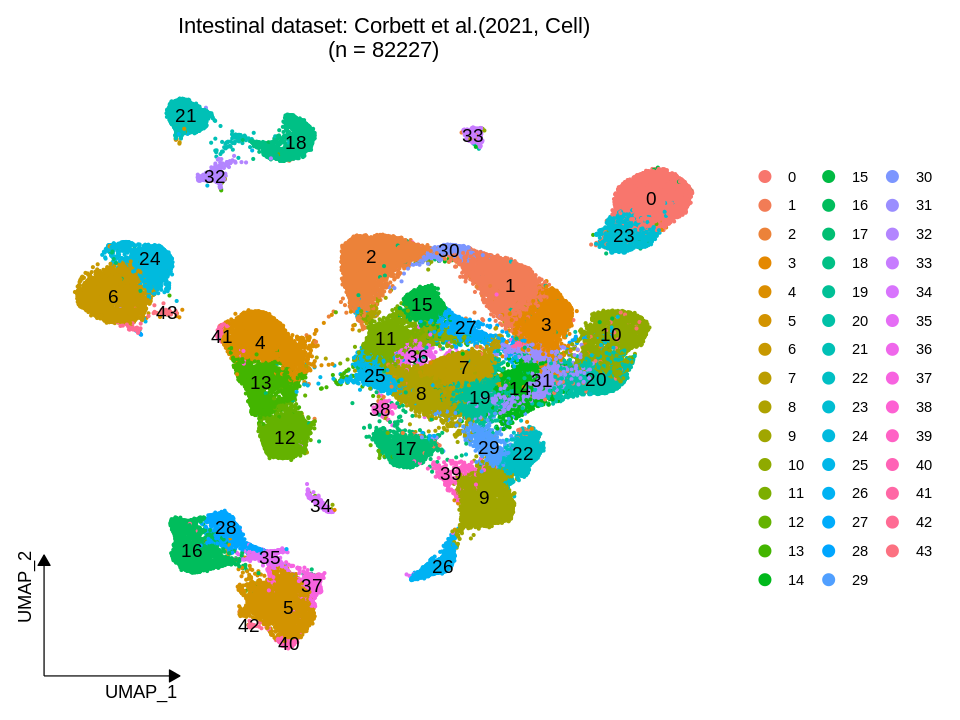

In [16]:
options(repr.plot.width = 8, repr.plot.height = 6)
DimPlot(obj.sc, cols = cols, pt.size = 0.5, label = TRUE, group.by = 'seurat_clusters') + theme_dr(xlength = 0.2, ylength = 0.2, arrow = grid::arrow(length = unit(0.1, "inches"), ends = 'last', type = "closed")) + theme(panel.grid = element_blank(), plot.title = element_text(hjust = 0.5)) + ggtitle(sprintf('Intestinal dataset: Corbett et al.(2021, Cell)\n(n = %g)', ncol(obj.sc)))
ggsave(file.path(out.figs.dir, 'Intestinal.SC.clusters.UMAP.pdf'), width = 8, height = 6)
ggsave(file.path(out.figs.dir, 'Intestinal.SC.clusters.UMAP.eps'), width = 8, height = 6)

### Annotation for the clusters

In [17]:
de.markers <- FindAllMarkers(obj.sc, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14

Calculating cluster 15

Calculating cluster 16

Calculating cluster 17

Calculating cluster 18

Calculating cluster 19

Calculating cluster 20

Calculating cluster 21

Calculating cluster 22

Calculating cluster 23

Calculating cluster 24

Calculating cluster 25

Calculating cluster 26

Calculating cluster 27

Calculating cluster 28

Calculating cluster 29

Calculating cluster 30

Calculating cluster 31

Calculating cluster 32

Calculating cluster 33

Calculating cluster 34

Calculating cluster 35

Calculating cluster 36

Calculating cluster 37

Calculating cluster 38

Calculating cluster 39

Calculating cluster 40

Calculating cluster 41

Ca

In [18]:
saveRDS(de.markers, file = file.path(out.data.dir, 'intestinal.de.markers.rds'))
openxlsx::write.xlsx(de.markers, file = file.path(out.data.dir, 'intestinal.de.markers.xlsx'))

In [94]:
de.markers <- readRDS(file.path(out.data.dir, 'intestinal.de.markers.rds'))

In [95]:
head(de.markers)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
C1QTNF3,0,2.064408,0.722,0.141,0,0,C1QTNF3
COL1A1,0,2.030015,0.992,0.682,0,0,COL1A1
FBLN1,0,1.930109,0.914,0.412,0,0,FBLN1
COL1A2,0,1.913317,0.990,0.664,0,0,COL1A2
DCN,0,1.858696,0.968,0.445,0,0,DCN
OGN,0,1.839180,0.895,0.289,0,0,OGN


In [98]:
ref.anno <- lapply(1 : 9, function(idx) {
    ref.anno <- openxlsx::read.xlsx('../0.data/Intestinal/Supplementary_data_Mendeley.xlsx', sheet = idx)
    as.data.frame(ref.anno)
}) %>% do.call(rbind, .) 

In [99]:
head(ref.anno)

,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,0,1.923030,0.923,0.092,0,Endothelium G2M-phase,CENPF
2,0,1.811886,0.893,0.053,0,Endothelium G2M-phase,UBE2C
3,0,1.694315,0.879,0.088,0,Endothelium G2M-phase,TOP2A
4,0,1.603219,0.896,0.067,0,Endothelium G2M-phase,NUSAP1
5,0,1.535787,0.891,0.052,0,Endothelium G2M-phase,MKI67
6,0,1.513403,0.843,0.041,0,Endothelium G2M-phase,ASPM


In [100]:
broad.anno <- openxlsx::read.xlsx('../0.data/Intestinal/Supplementary_data_Mendeley.xlsx', sheet = 10)

In [101]:
top.n <- 30
qry.markers <- de.markers %>% subset(., p_val_adj < 0.01) %>% group_by(cluster) %>% top_n(n = top.n, wt = avg_log2FC)
ref.markers <- ref.anno %>% subset(., p_val_adj < 0.01) %>% group_by(cluster) %>% top_n(n = top.n, wt = avg_logFC)
broad.markers <- broad.anno %>% subset(., p_val_adj < 0.01) %>% group_by(cluster) %>% top_n(n = top.n, wt = avg_logFC)

In [102]:
qry.markers.lst <- split(qry.markers$gene, qry.markers$cluster)
ref.markers.lst <- split(ref.markers$gene, ref.markers$cluster)
broad.markers.lst <- split(broad.markers$gene, broad.markers$cluster)

In [103]:
broad.ovp.markers <- lapply(qry.markers.lst, function(xx) {
    lapply(broad.markers.lst, function(yy) {
        intersect(xx, yy)
    })
})

In [104]:
refine.ovp.markers <- lapply(qry.markers.lst, function(xx) {
    lapply(ref.markers.lst, function(yy) {
        intersect(xx, yy)
    })
})

In [116]:
broad.ovp.markers[['36']][2]

$Epithelium
 [1] "TSPAN8" "AGR2"   "MT1G"   "MT1H"   "MT1E"   "CLDN3"  "ELF3"   "EPCAM" 
 [9] "CLDN4"  "MT1X"   "MT1F"   "AGR3"   "KRT18"  "KRT8"   "MT2A"   "LGALS3"

In [26]:
new.idents <- c(
    '0' = 'Fibroblasts Transitional',
    '1' = 'Fibroblasts S1',
    '2' = 'Fibroblasts Distal',
    '3' = 'Fibroblasts Progenitor',
    '4' = 'Muscularis',
    '5' = 'Differentiating Submucosal Glial',
    '6' = 'Venous',
    '7' = 'Myofibroblasts',
    '8' = 'Goblet',
    '9' = 'WNT6+ Pericytes',
    '10' = 'Proximal Enterocytes',
    '11' = 'Fibroblasts Transitional',
    '12' = 'Fibroblasts HAND1+',
    '13' = 'Muscularis',
    '14' = 'Distal Enterocytes',
    '15' = 'Fibroblasts Transitional',
    '16' = 'Neuroendocrine',
    '17' = 'Pericytes Cycling',
    '18' = 'Macrophages/DCs',
    '19' = 'Myofibroblast Progenitors', 
    '20' = 'Distal Enterocytes',
    '21' = 'Naive T-Cells',
    '22' = 'Pericytes',
    '23' = 'Fibroblasts Cycling',
    '24' = 'Arterial',
    '25' = 'Fibroblasts Transitional',
    '26' = 'EECs',
    '27' = 'Enterocytes',
    '28' = 'Neuroendocrine',
    '29' = 'Pericytes',
    '30' = 'Fibroblasts IFIT3+',
    '31' = 'Distal Enterocytes',
    '32' = 'B-Cells',
    '33' = 'BEST4/OTOP2 Cells',
    '34' = 'Mesothelium',
    '35' = 'ENS Progenitors',
    '36' = 'Goblet',
    '37' = 'Neural Cycling',
    '38' = 'UNKNOWN',
    '39' = 'Pericytes Cycling',
    '40' = 'Lymphoid Associated Glial',
    '41' = 'Muscularis',
    '42' = 'Venous',
    '43' = 'Muscularis'
)

In [27]:
#broad.ovp.markers[['8']]
#refine.ovp.markers[['8']]

In [28]:
Idents(obj.sc) <- obj.sc$seurat_clusters

In [29]:
obj.sc <- RenameIdents(obj.sc, new.idents)

In [30]:
order.ctypes <- c(
    'Venous', 'Arterial', # Endothelial 
    'Enterocytes', 'Proximal Enterocytes', 'Distal Enterocytes', 'EECs', 'BEST4/OTOP2 Cells', 'Goblet', # Epithelial
    'Fibroblasts Progenitor', 'Fibroblasts Transitional', 'Fibroblasts Cycling', 'Fibroblasts Distal', 'Fibroblasts S1', 'Fibroblasts HAND1+', 'Fibroblasts IFIT3+', # Fibroblasts 
    'Myofibroblast Progenitors', 'Myofibroblasts',  # Myofibroblasts
    'Muscularis', # Muscle 
    'Mesothelium', # Mesothelium
    'ENS Progenitors', 'Differentiating Submucosal Glial', 'Neuroendocrine', 'Neural Cycling', 'Lymphoid Associated Glial', # Neural
    'Pericytes', 'WNT6+ Pericytes', 'Pericytes Cycling', # Pericytes
    'B-Cells', 'Macrophages/DCs', 'Naive T-Cells', # Immune
    'UNKNOWN'
)

In [31]:
levels(obj.sc) <- order.ctypes

In [32]:
length(order.ctypes)

[1] 31

In [33]:
cols <- randomcoloR::distinctColorPalette(length(levels(obj.sc)), runTsne = TRUE) %>% `levels<-`(levels(obj.sc))

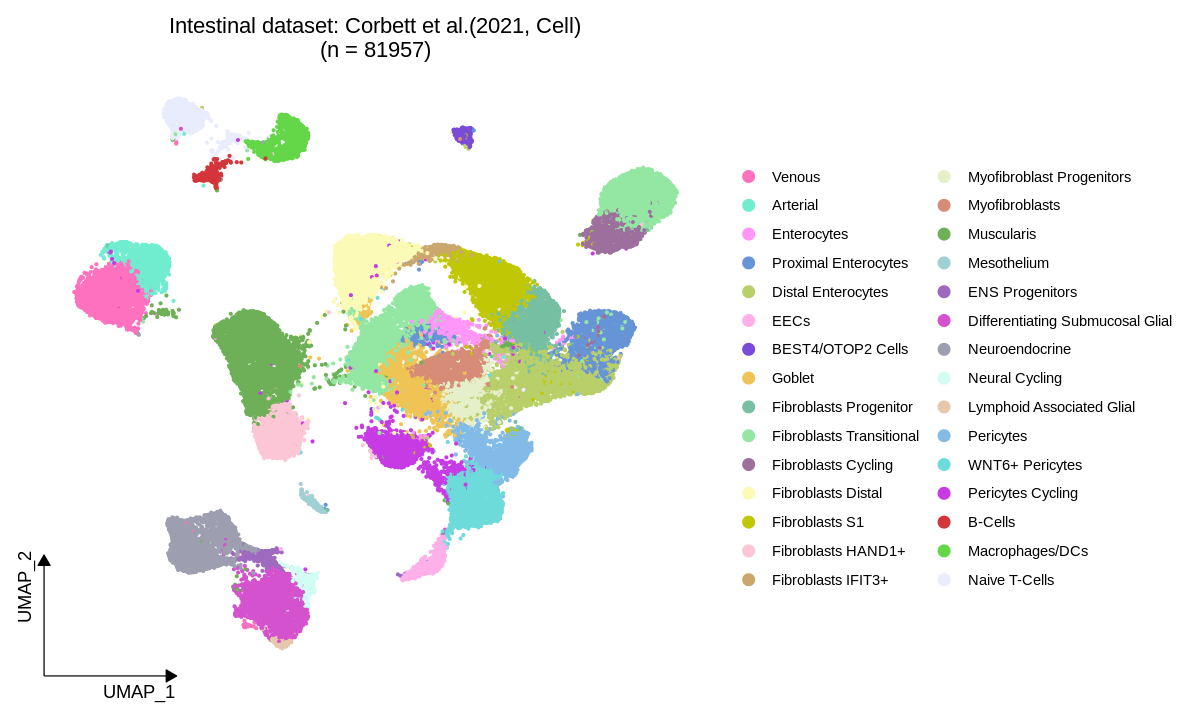

In [124]:
options(repr.plot.width = 10, repr.plot.height = 6)
DimPlot(obj.sc, cols = cols, pt.size = 0.5, label = FALSE) + theme_dr(xlength = 0.2, ylength = 0.2, arrow = grid::arrow(length = unit(0.1, "inches"), ends = 'last', type = "closed")) + theme(panel.grid = element_blank(), plot.title = element_text(hjust = 0.5)) + ggtitle(sprintf('Intestinal dataset: Corbett et al.(2021, Cell)\n(n = %g)', ncol(obj.sc)))
ggsave(file.path(out.figs.dir, 'Intestinal.SC.clusters.anno.UMAP.pdf'), width = 10, height = 6)
ggsave(file.path(out.figs.dir, 'Intestinal.SC.clusters.anno.UMAP.eps'), width = 10, height = 6)

### Assessment of annotation results

In [36]:
marker.genes <- c('PTPRC', 'EPCAM', 'PECAM1', 'PHOX2B', 'BGN', 'ACTG2', 'KLK11', 'COL1A1', 'PITX1')

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


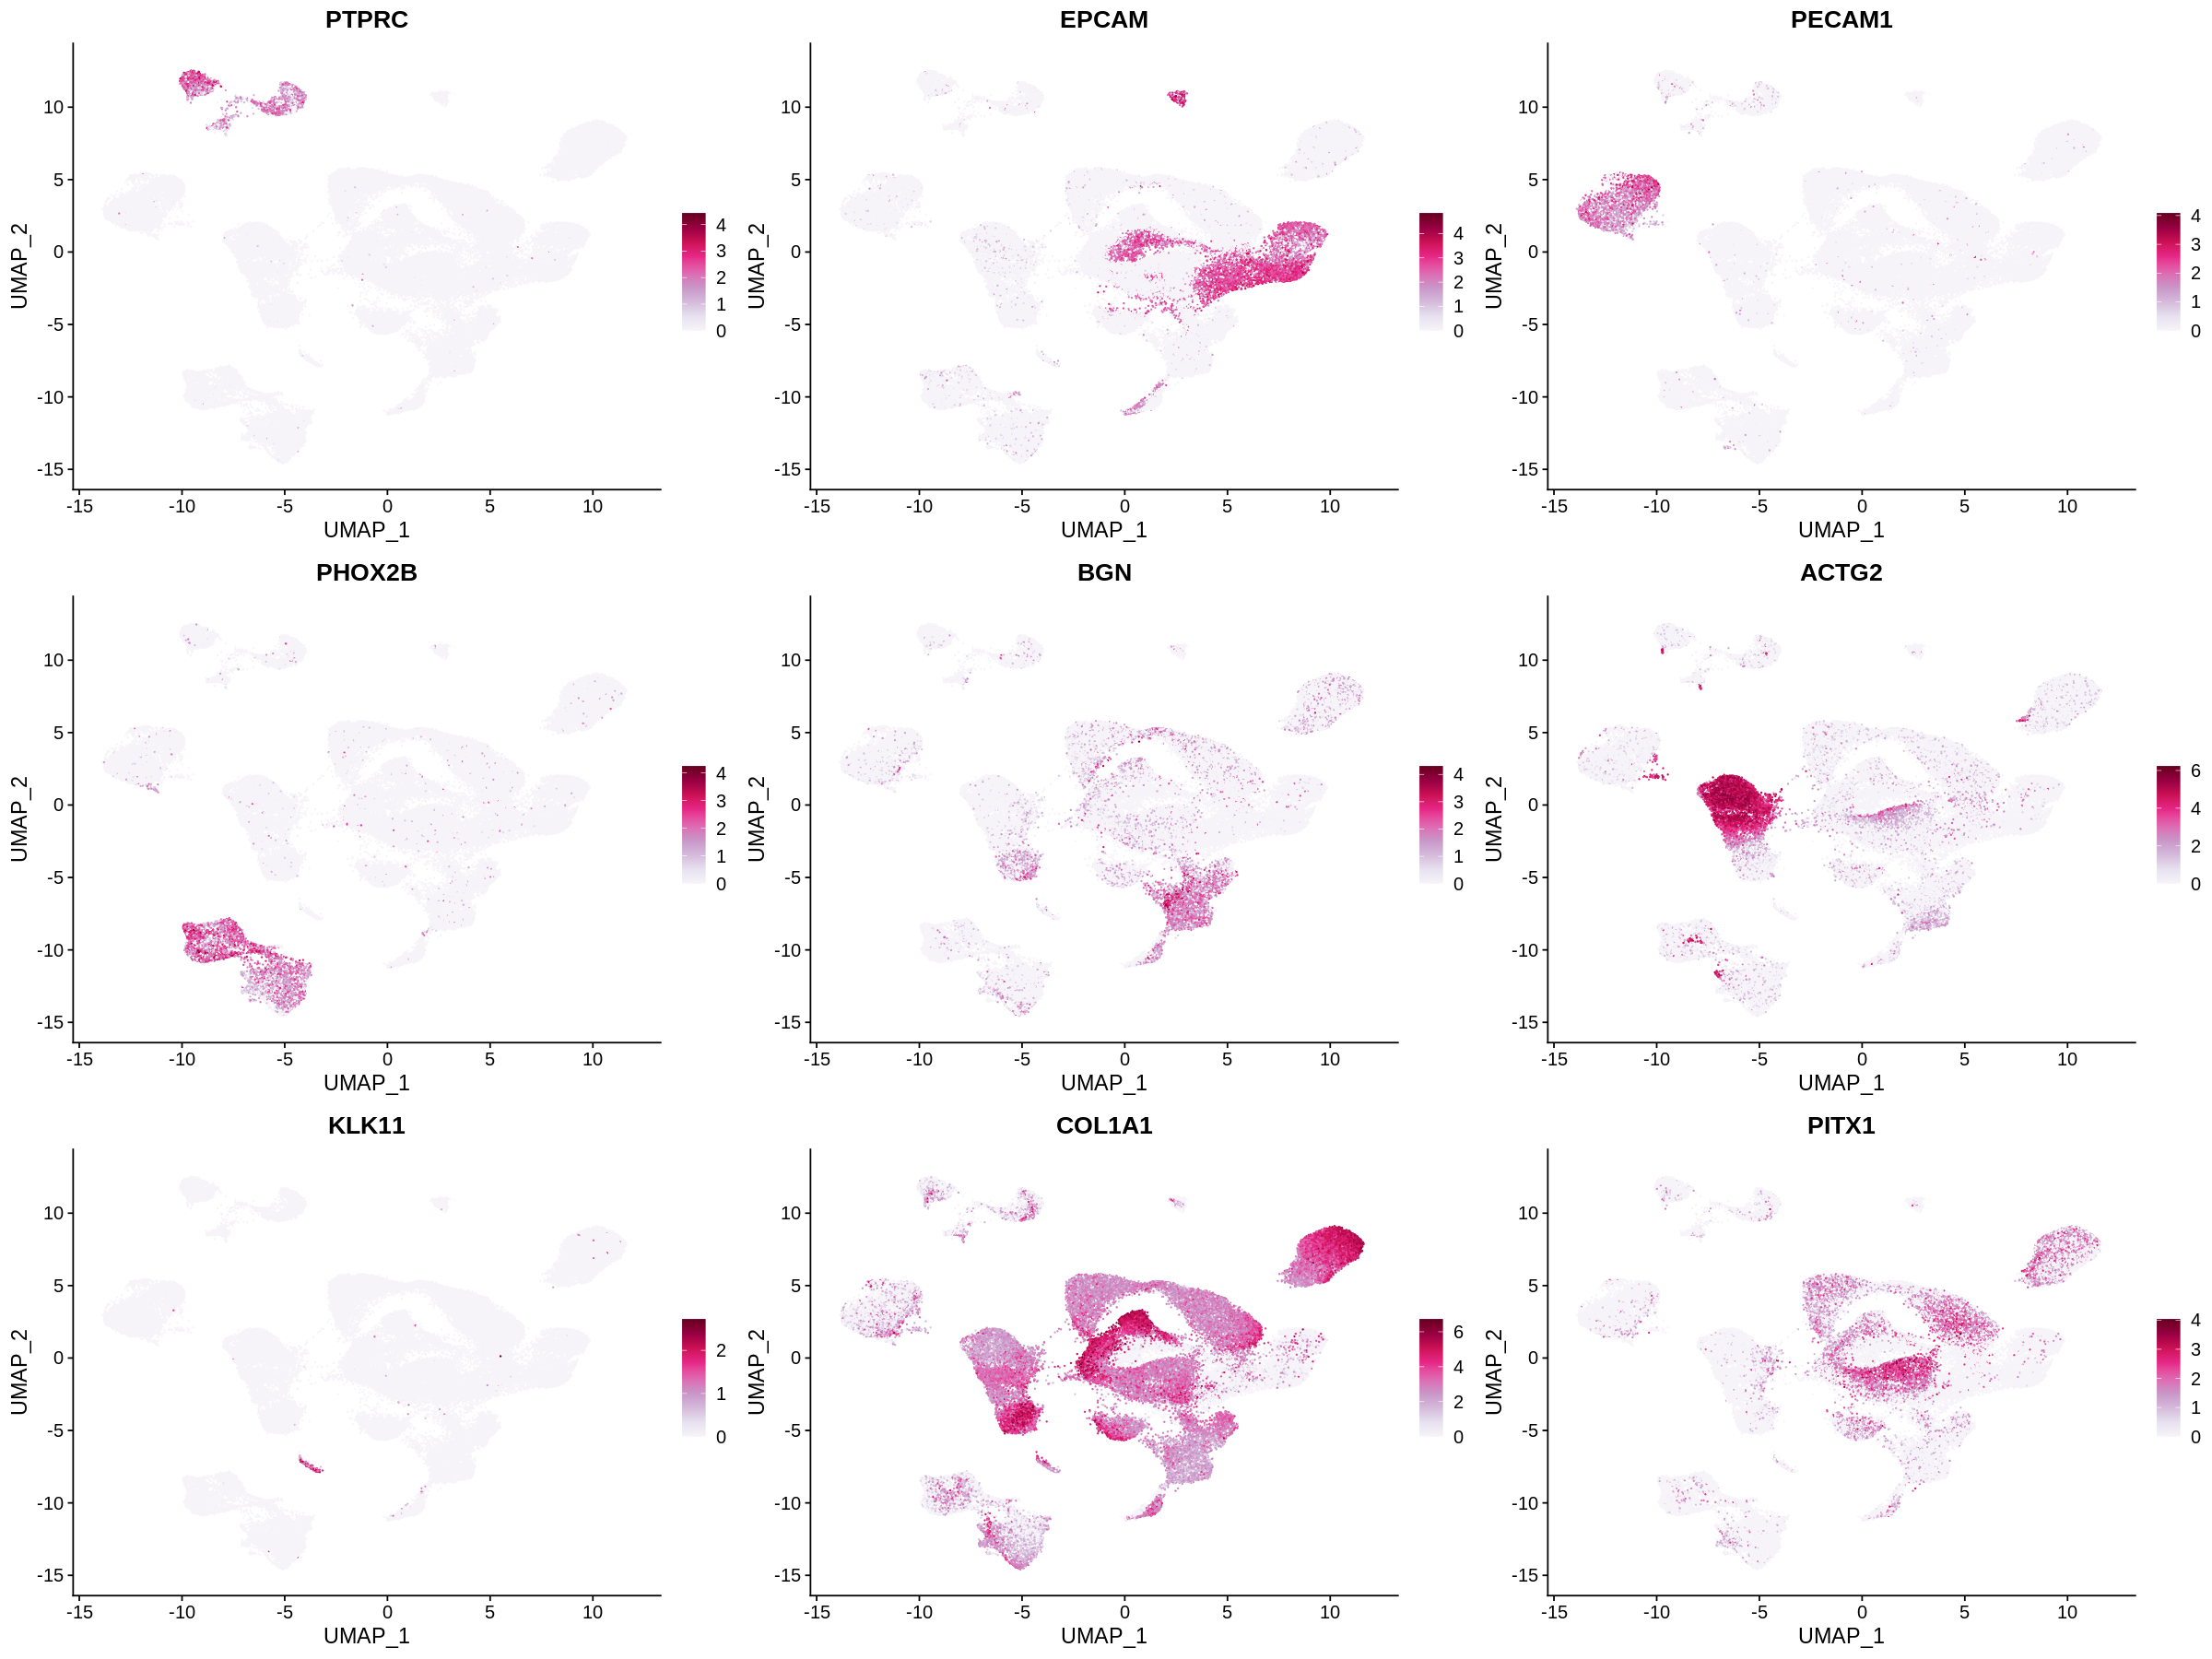

In [123]:
options(repr.plot.width = 20, repr.plot.height = 15)
ps <- FeaturePlot(obj.sc, features = marker.genes, combine = FALSE)
for(i in 1:length(ps)) {
  ps[[i]] <- ps[[i]] + scale_color_gradientn(colors = RColorBrewer::brewer.pal(11 ,"PuRd"))
}

CombinePlots(ps, ncol = 3)
ggsave(file.path(out.figs.dir, 'Intestinal.SC.features.UMAP.pdf'), width = 20, height = 15)
ggsave(file.path(out.figs.dir, 'Intestinal.SC.features.UMAP.eps'), width = 20, height = 15)

In [47]:
obj.sc <- subset(obj.sc, idents = 'UNKNOWN', invert = TRUE)

In [48]:
dim(obj.sc)

[1] 22529 81957

In [55]:
qry.markers <- de.markers %>% subset(., p_val_adj < 0.01) %>% group_by(cluster) %>% top_n(n = 40, wt = avg_log2FC)

In [56]:
expr.avg <- AverageExpression(obj.sc, slot = 'scale.data')$RNA
#expr.avg <- expr.avg[VariableFeatures(obj.sc), ]
expr.avg <- expr.avg[intersect(VariableFeatures(obj.sc), unique(qry.markers$gene)), ]

In [57]:
anno.dat <- c(rep('Endothelial', 2), rep('Epithelial', '6'), rep('Fibroblasts', 7), rep('Myofibroblasts', 2), 'Muscularis', 'Mesothelium', rep('Neural', 5), rep('Pericytes', 3), rep('Immune', 3))
anno.col <- data.frame(anno = anno.dat) %>% `rownames<-`(colnames(expr.avg))

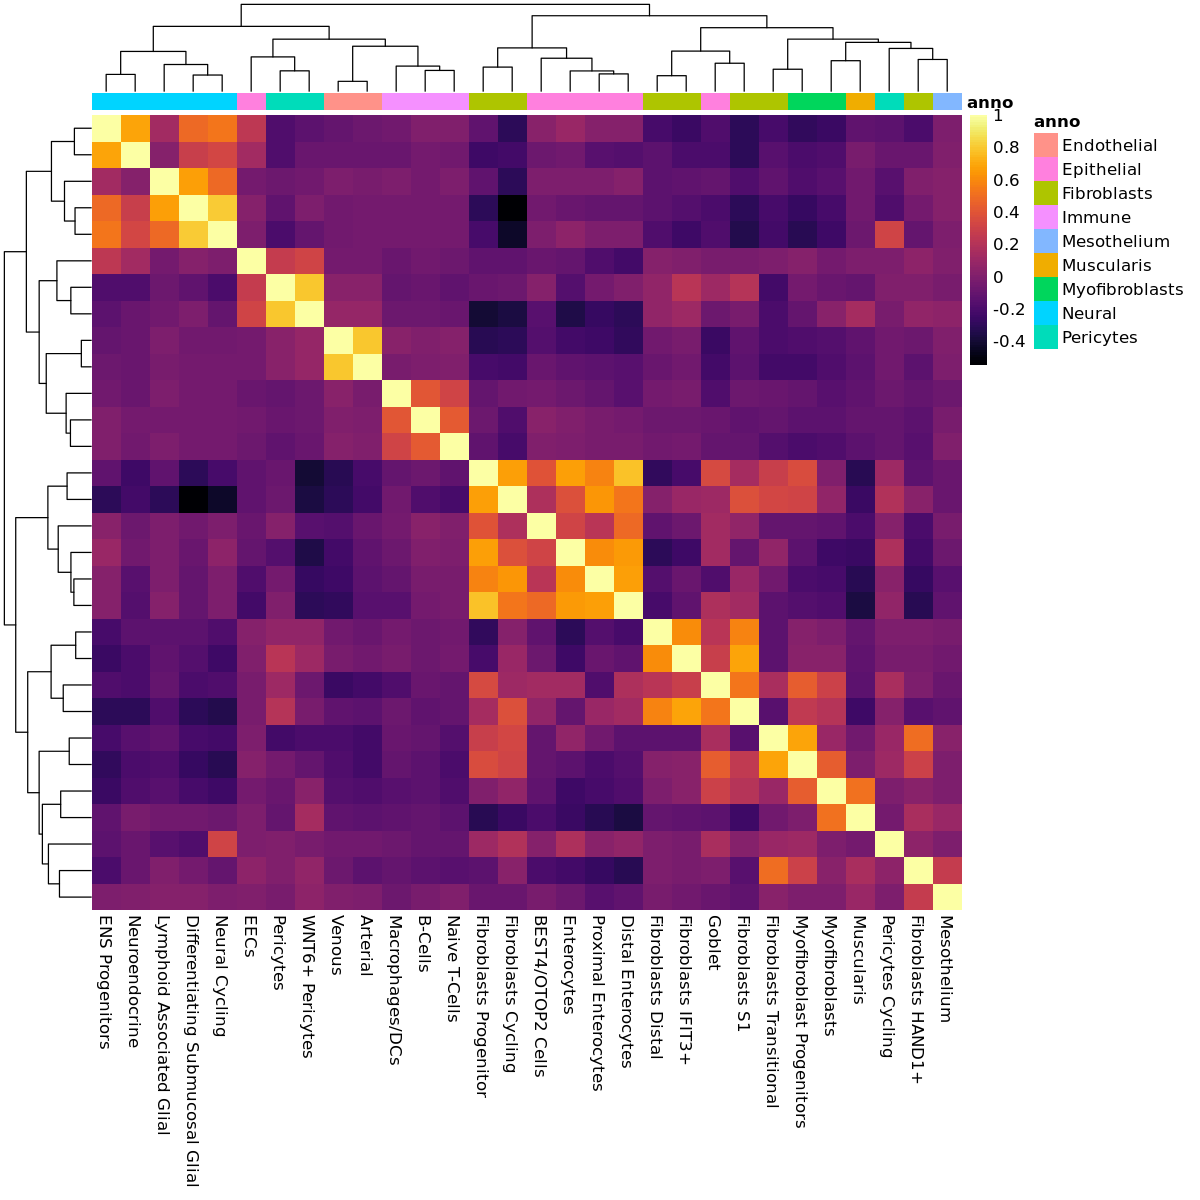

In [58]:
options(repr.plot.width = 10, repr.plot.height = 10)

pheatmap::pheatmap(cor(expr.avg), show_rownames = FALSE, border_color = NA, annotation_col = anno.col, color = viridis::inferno(100))
pheatmap::pheatmap(cor(expr.avg), show_rownames = FALSE, border_color = NA, annotation_col = anno.col, color = viridis::inferno(100), filename = file.path(out.figs.dir, 'Corr.anno.subsets.heatmap.pdf'), width = 10, height = 10)

In [122]:
saveRDS(obj.sc, file = file.path(out.data.dir, 'obj.sc.RDS'))